## Environment

In [292]:
from sklearn.model_selection import RepeatedKFold
from hyperopt import tpe, hp, fmin, STATUS_OK
from sklearn.model_selection import KFold
from hyperopt.pyll import scope
from hyperopt import Trials

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from lightgbm import plot_importance
import lightgbm as lgb
import pandas as pd
import numpy as np

In [293]:
from IPython.display import clear_output
SEED = 1337; np.random.seed(SEED)
rss= np.random.default_rng (SEED)
TARGET_COL = "num_price"

## Load inputs

In [294]:
df   = pd.read_parquet("./.data/features")
print(df.shape)

(5547, 26)


## Drop outliers in target

In [295]:
# use the 1.5 * IQR rule
q1 = np.quantile(df[TARGET_COL], 0.25); q3 = np.quantile(df[TARGET_COL], 0.75); iqr = q3 - q1
cond = "(df[TARGET_COL] <= q1 - 1.5 * iqr) | (df[TARGET_COL] >= q3 + 1.5 * iqr)"
outliers = df.loc[eval(cond), ["num_price", "num_area"]]
df = df.loc[~eval(cond), :]
ids_ = df.pop("id")

print(f"IQR-based MIN outlier price: {outliers[TARGET_COL].min()}")
print(f"IQR-based MAX outlier price: {outliers[TARGET_COL].max()}")
print(f"IQR-based num of outliers  : {outliers.shape[0]}")

IQR-based MIN outlier price: 17.212324
IQR-based MAX outlier price: 129.0
IQR-based num of outliers  : 379


## Index categorical features

In [296]:
# separate features and target
X = df; y = X.pop(TARGET_COL)
cat_features = [col for col in X.columns if "cat" in col]

# int-encode cat feature levels
encoder_feature_maps = {}
decoder_feature_maps = {}
for feature in cat_features:
    levels = X[feature].unique()
    encoder_feature_map = {level: idx for idx, level in enumerate(levels)}
    encoder_feature_maps.update({feature: encoder_feature_map})
    decoder_feature_map = {idx: level for idx, level in enumerate(levels)}
    decoder_feature_maps.update({feature: encoder_feature_map})
    df[feature] = df[feature].map(encoder_feature_map)

# append flag features to categorical features list
cat_features = cat_features + [col for col in X.columns if "has" in col  ]

## Sample test set and prepare K-fold cross-validation

In [297]:
# make index and shuffle to ensure rand
idx = np.arange(df.shape[0])
np.random.shuffle(idx)

# sample test set
num_test_obs = 750
test_idx = idx[:num_test_obs]
X_test = X.iloc[test_idx,:  ]
y_test = y.iloc[test_idx    ]
idx    = idx[num_test_obs:  ]

# prepare K-folds
train_folds = []
valid_folds = []
for train_idx, valid_idx in KFold(n_splits=5, shuffle=True).split(idx):
    
    # subset train / valid folds
    X_train = X.iloc[train_idx, :]; y_train = y.iloc[train_idx]
    X_valid = X.iloc[valid_idx, :]; y_valid = y.iloc[valid_idx]

    # collect materialized folds
    train_folds.append((X_train, y_train))
    valid_folds.append((X_valid, y_valid))

## Establish trivial benchmarks to be beaten

In [298]:
valid_fold_loss = []
# iterate over folds
for (X_train, y_train), (X_valid, y_valid) in zip(train_folds, valid_folds):
    h_valid = [np.mean(y_train) for _ in range(len(y_valid))]
    mae = mean_absolute_error(y_valid, h_valid)
    valid_fold_loss.append(mae)

# compute total loss
valid_loss = np.mean(valid_fold_loss )
print(f"Simple mean validation MAE: {valid_loss}")

Simple mean validation MAE: 2.485513554540675


In [299]:
valid_fold_loss = []
# iterate over folds
num_features = [col for col in X.columns if "num" in col] + [col for col in X.columns if "has" in col]
for (X_train, y_train), (X_valid, y_valid) in zip(train_folds, valid_folds):

    X_train = X_train.loc[:, num_features]
    X_valid = X_valid.loc[:, num_features]
    model   = LinearRegression().fit(X_train, y_train)
    valid_fold_loss.append(mean_absolute_error(y_valid, model.predict(X_valid)))

# compute total loss
valid_loss = np.mean(valid_fold_loss )
print(f"Simple num-feature OLS validation MAE: {valid_loss}")

Simple num-feature OLS validation MAE: 1.5541430517907364


## Tune a LightGBM regressor with hyperopt

In [300]:
hyperparam_space = {
    "n_estimators"       : scope.int(hp.quniform("n_estimators", 100 , 750, 1)), # capacity param (related to learning_rate) -- tunable
    "num_leaves"         : scope.int(hp.quniform("num_leaves"  , 5   , 80 , 1)), # capacity param (related to max_depth    ) -- tunable
    "learning_rate"      : hp.uniform("learning_rate"   , 0.01, 0.1)           , # capacity param (related to n_estimators ) -- tunable 
    "colsample_bytree"   : hp.uniform("colsample_bytree", 0.50, 1.0)           , # reg. param -- tunable
    "reg_lambda"         : hp.uniform("reg_lambda"      , 0.00, 0.3)           , # reg. param -- tunable
    "subsample"          : hp.uniform("subsample"       , 0.50, 1.0)           , # reg. param -- tunable
}

constant_params  = {
    "objective"          : "l2", # Mean Squared Error
    "max_depth"          : -1  , # capacity param
    "max_bin"            : 450 , # reg. param
    "subsample_freq"     : 5   , # reg. param
    "force_row_wise"     : True, # compute param
    "n_jobs"             : -1  , # compute param
    "seed"               : SEED, # compute param
    "verbose"            : -1  , # compute param
}

def objective(params):

    # make loss containers
    train_fold_loss = []
    valid_fold_loss = []

    # iterate over folds
    for (X_train, y_train), (X_valid, y_valid) in zip(train_folds, valid_folds):

        # fit a model
        model = (
            lgb.LGBMRegressor(**params, **constant_params) .fit(
                X_train, y_train, feature_name=X.columns.tolist(), 
                categorical_feature=cat_features,
            )
        )
        
        # compute loss
        mse = mean_squared_error(y_valid, model.predict(X_valid))
        valid_fold_loss.append(np.sqrt(mse)) 
        mse = mean_squared_error(y_train, model.predict(X_train))
        train_fold_loss.append(np.sqrt(mse))
    
    clear_output()
    # compute total loss
    valid_loss = np.mean(valid_fold_loss)
    train_loss = np.mean(train_fold_loss)
    
    return {
        "loss": valid_loss + (valid_loss - train_loss), 
        "valid_loss": valid_loss, 
        "train_loss": train_loss, 
        "status": STATUS_OK
    }

In [301]:
trials = Trials(); argmin = fmin(
    fn=objective, algo=tpe.suggest, max_evals=200,
    space=hyperparam_space, trials=trials, 
    rstate=rss,
)

100%|██████████| 200/200 [05:24<00:00,  1.62s/trial, best loss: 1.5000136595495897]


In [302]:
parsed_trials = []
for trial in trials:

    # extract loss vals and params
    vloss  = trial["result"]["valid_loss"]
    tloss  = trial["result"]["train_loss"]
    loss   = trial["result"]["loss"]
    params = trial["misc"  ]["vals"]

    # put together parsed trial
    params = {k:v[0] for k, v in params.items()}
    result = {**{"train_loss": tloss}, **params}
    result = {**{"valid_loss": vloss}, **result}
    result = {**{"loss": loss}, **result}
    parsed_trials.append(result)

# report parsed trials
parsed_trials = pd.DataFrame(parsed_trials)
parsed_trials.sort_values("loss").head(10 )

,loss,valid_loss,train_loss,colsample_bytree,learning_rate,n_estimators,num_leaves,reg_lambda,subsample
144,1.500014,1.358995,1.217976,0.755258,0.045513,287.0,5.0,0.207164,0.950021
116,1.501042,1.377538,1.254035,0.742308,0.054978,120.0,7.0,0.129544,0.940970
143,1.502097,1.361845,1.221593,0.755330,0.046308,211.0,6.0,0.191448,0.946643
159,1.502852,1.350004,1.197157,0.635810,0.048420,246.0,6.0,0.241556,0.953368
191,1.504054,1.416013,1.327972,0.550708,0.040892,130.0,6.0,0.226935,0.978685
184,1.504083,1.354711,1.205338,0.677470,0.033640,422.0,5.0,0.176628,0.985516
128,1.505492,1.362652,1.219811,0.699443,0.064060,160.0,6.0,0.207376,0.883888
90,1.507270,1.384930,1.262589,0.965575,0.052977,113.0,7.0,0.093060,0.907228
168,1.509054,1.445605,1.382156,0.520436,0.032573,142.0,6.0,0.234975,0.517663
66,1.509092,1.360538,1.211985,0.887812,0.048816,279.0,5.0,0.281479,0.793745


## Compute test error

In [303]:
X_train_full = pd.concat((train_folds[0][0], valid_folds[0][0]), axis=0, ignore_index=True)
y_train_full = pd.concat((train_folds[0][1], valid_folds[0][1]))

argmin["n_estimators"] = int(argmin["n_estimators"])
argmin["num_leaves"  ] = int(argmin["num_leaves"  ])

full_model   = (
    lgb.LGBMRegressor(**argmin, **constant_params) .fit(
        X_train_full, y_train_full, 
        feature_name=X.columns.tolist() , 
        categorical_feature=cat_features,
    )
)

clear_output()

Test MAE: 0.879221852214562, Test RMSE: 1.2258584285801113


<AxesSubplot: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

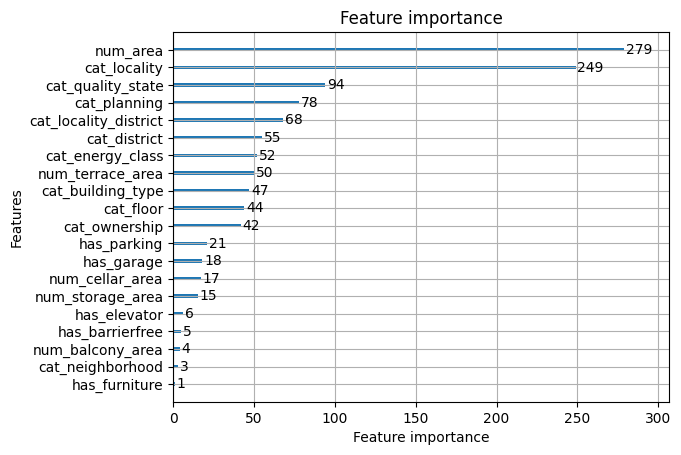

In [304]:
test_rmse = np.sqrt(mean_squared_error(y_test, full_model.predict(X_test)))
test_mae = mean_absolute_error(y_test, full_model.predict(X_test))
print(f"Test MAE: {test_mae}, Test RMSE: {test_rmse}")
plot_importance(full_model)

## Estimating prediction error with repeated K-fold

In [305]:
mae = []
idx = np.arange(X.shape[0])
rkf = RepeatedKFold(n_splits=10, n_repeats=30, random_state=SEED )
for fold_idx, (train_idx, valid_idx) in enumerate(rkf.split(idx)):

    X_train = X.iloc[train_idx, :]; y_train = y.iloc[train_idx]
    X_valid = X.iloc[valid_idx, :]; y_valid = y.iloc[valid_idx]

    full_model   = (
        lgb.LGBMRegressor(**argmin, **constant_params) .fit(
            X_train_full, y_train_full, 
            feature_name=X.columns.tolist() , 
            categorical_feature=cat_features,
        )
    )

    mae_ = mean_absolute_error(y_valid, full_model.predict(X_valid))
    mae.append(mae_)
    print(fold_idx )
    clear_output(  )

mae_std = np.std (mae)
mae_avg = np.mean(mae)
pessimistic_mae  = mae_avg + 2 * mae_std
print(f"MAE mean: {mae_avg}, MAE std: {mae_std}, pissimistic MAE: {pessimistic_mae}")

MAE mean: 0.8752155465779767, MAE std: 0.036010568106423856, pissimistic MAE: 0.9472366827908244


## Make expected price estimates

In [306]:
final_model = (
    lgb.LGBMRegressor(**argmin, **constant_params) .fit(
        X, y, feature_name=X.columns.tolist() , 
        categorical_feature=cat_features,
    )
)

clear_output()
estimated_price = final_model.predict(X)
estimated_price_lower = estimated_price - pessimistic_mae
estimated_price_upper = estimated_price + pessimistic_mae

output = pd.DataFrame(
    {
        "id": ids_,
        "asked_price": y,
        "estimated_price_lower": estimated_price_lower,
        "estimated_price"      : estimated_price,
        "estimated_price_upper": estimated_price_upper,
    }
)


In [307]:
# find over-priced and under-priced apartments
underpriced = output.loc[output["asked_price"] <= output["estimated_price_lower"], :  ].copy()
overpriced  = output.loc[output["asked_price"] >= output["estimated_price_upper"], :  ].copy()
underpriced["delta"] = (output["asked_price"]  / output["estimated_price_lower"]) - 1.0
overpriced ["delta"] = (output["asked_price"]  / output["estimated_price_upper"]) - 1.0

# filter out outliers
underpriced = underpriced.loc[underpriced.delta >= -0.15, :]
overpriced  = overpriced .loc[overpriced .delta <=  0.15, :]

In [308]:
print(f"Num underpriced apartments: {underpriced.shape[0]}")
underpriced.sort_values("delta", ascending=True ).head( 10 )

Num underpriced apartments: 648


,id,asked_price,estimated_price_lower,estimated_price,estimated_price_upper,delta
4647,1238824524,2.99,3.513368,4.460604,5.407841,-0.148965
4645,1379346252,4.30,5.052515,5.999751,6.946988,-0.148939
1344,188962908,3.79,4.445560,5.392796,6.340033,-0.147464
342,2343839564,9.50,11.141547,12.088784,13.036020,-0.147336
3170,2370131788,7.99,9.348752,10.295989,11.243225,-0.145340
653,2067572556,4.30,5.030823,5.978059,6.925296,-0.145269
4731,1211601996,8.90,10.409865,11.357102,12.304338,-0.145042
1270,3584583500,4.00,4.678532,5.625768,6.573005,-0.145031
2790,2185401420,4.12,4.815917,5.763153,6.710390,-0.144503
4586,3134985804,3.59,4.190881,5.138118,6.085354,-0.143378


In [309]:
print(f"Num overpriced apartments: {overpriced .shape[0]}")
overpriced .sort_values("delta", ascending=False ).head(10)

Num overpriced apartments: 743


,id,asked_price,estimated_price_lower,estimated_price,estimated_price_upper,delta
4461,3244001100,6.736112,3.963445,4.910681,5.857918,0.149916
1212,4182109020,17.124500,13.007908,13.955145,14.902382,0.149112
1694,2769246028,7.690000,4.798174,5.745410,6.692647,0.149022
1918,3355907916,10.950000,7.647506,8.594742,9.541979,0.147561
441,878486604,13.500000,9.870619,10.817855,11.765092,0.147462
1855,850377052,13.990000,10.312893,11.260129,12.207366,0.146029
3858,1478510412,15.450000,11.589423,12.536659,13.483896,0.145811
1116,508761932,5.534000,2.937763,3.885000,4.832237,0.145225
3635,177538892,13.900000,10.257965,11.205202,12.152439,0.143803
478,2443628124,16.948921,12.929215,13.876451,14.823688,0.143367
